# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
!unzip processed_celeba_small.zip

Archive:  processed_celeba_small.zip
replace processed_celeba_small/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=transform)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

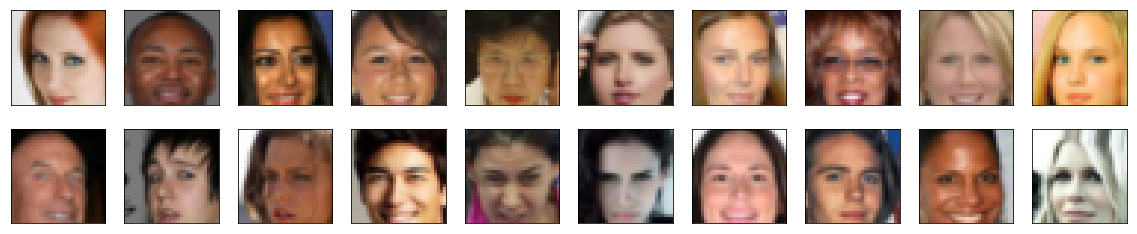

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8824)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

In [10]:
# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 16x16 out
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8 out
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # all hidden layers + leaky relu activation
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [12]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [13]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
       

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        # fully-connected + reshape 
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # hidden transpose conv layers + relu
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        
        # last layer + tanh activation
        out = self.t_conv3(out)
        out = F.tanh(out)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
           # init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)
    
    
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [16]:
# Define model hyperparams
d_conv_dim = g_conv_dim = 32 
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [19]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
# params
lr = 0.0002
beta1=0.5
beta2=0.999 # default value

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [20]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # Train the discriminator on real and fake images
            d_optimizer.zero_grad()
        
            # 1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # 2. Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [21]:
# set number of epochs 
n_epochs = 70


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from workspace_utils import active_session

with active_session():
     # call training function
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   70] | d_loss: 1.4553 | g_loss: 0.8525
Epoch [    1/   70] | d_loss: 0.2448 | g_loss: 2.6174
Epoch [    1/   70] | d_loss: 0.1234 | g_loss: 4.9277
Epoch [    1/   70] | d_loss: 0.2501 | g_loss: 4.1057
Epoch [    1/   70] | d_loss: 0.9654 | g_loss: 2.5245
Epoch [    1/   70] | d_loss: 0.3389 | g_loss: 1.9852
Epoch [    1/   70] | d_loss: 0.6892 | g_loss: 1.4061
Epoch [    1/   70] | d_loss: 0.6236 | g_loss: 1.7327
Epoch [    1/   70] | d_loss: 0.6996 | g_loss: 2.2550
Epoch [    1/   70] | d_loss: 0.7377 | g_loss: 1.9115
Epoch [    1/   70] | d_loss: 0.8118 | g_loss: 1.4759
Epoch [    1/   70] | d_loss: 1.2314 | g_loss: 2.2257
Epoch [    1/   70] | d_loss: 1.0921 | g_loss: 1.5225
Epoch [    1/   70] | d_loss: 1.1749 | g_loss: 1.8421
Epoch [    1/   70] | d_loss: 0.9480 | g_loss: 0.8831
Epoch [    1/   70] | d_loss: 1.2939 | g_loss: 0.5395
Epoch [    1/   70] | d_loss: 0.9767 | g_loss: 1.3324
Epoch [    1/   70] | d_loss: 1.1183 | g_loss: 0.9102
Epoch [    1/   70] | d_loss

Epoch [    6/   70] | d_loss: 1.1027 | g_loss: 0.9870
Epoch [    6/   70] | d_loss: 1.1107 | g_loss: 2.1268
Epoch [    6/   70] | d_loss: 0.9157 | g_loss: 0.9110
Epoch [    6/   70] | d_loss: 1.1891 | g_loss: 0.9818
Epoch [    6/   70] | d_loss: 0.9106 | g_loss: 1.3245
Epoch [    6/   70] | d_loss: 0.9321 | g_loss: 1.4121
Epoch [    6/   70] | d_loss: 1.1244 | g_loss: 1.9153
Epoch [    6/   70] | d_loss: 0.8174 | g_loss: 1.5149
Epoch [    6/   70] | d_loss: 1.3667 | g_loss: 2.3757
Epoch [    6/   70] | d_loss: 1.0932 | g_loss: 1.6960
Epoch [    6/   70] | d_loss: 0.9061 | g_loss: 1.5298
Epoch [    6/   70] | d_loss: 0.8331 | g_loss: 1.9531
Epoch [    6/   70] | d_loss: 0.8859 | g_loss: 1.2433
Epoch [    6/   70] | d_loss: 0.7677 | g_loss: 1.8416
Epoch [    6/   70] | d_loss: 0.7670 | g_loss: 1.0509
Epoch [    6/   70] | d_loss: 0.7678 | g_loss: 1.5006
Epoch [    6/   70] | d_loss: 0.9171 | g_loss: 1.4643
Epoch [    6/   70] | d_loss: 0.7889 | g_loss: 1.4386
Epoch [    6/   70] | d_loss

Epoch [   11/   70] | d_loss: 0.5188 | g_loss: 2.2876
Epoch [   11/   70] | d_loss: 0.5574 | g_loss: 2.0927
Epoch [   11/   70] | d_loss: 0.5286 | g_loss: 1.3835
Epoch [   11/   70] | d_loss: 0.5263 | g_loss: 2.7832
Epoch [   11/   70] | d_loss: 0.5179 | g_loss: 1.0720
Epoch [   11/   70] | d_loss: 0.3404 | g_loss: 2.2852
Epoch [   11/   70] | d_loss: 0.7417 | g_loss: 2.3594
Epoch [   11/   70] | d_loss: 0.3123 | g_loss: 2.2751
Epoch [   11/   70] | d_loss: 1.0479 | g_loss: 1.1509
Epoch [   11/   70] | d_loss: 0.5899 | g_loss: 1.8408
Epoch [   11/   70] | d_loss: 0.4227 | g_loss: 2.1894
Epoch [   11/   70] | d_loss: 0.5860 | g_loss: 1.8772
Epoch [   11/   70] | d_loss: 0.3322 | g_loss: 3.2105
Epoch [   11/   70] | d_loss: 0.3800 | g_loss: 2.2614
Epoch [   11/   70] | d_loss: 0.7348 | g_loss: 3.2907
Epoch [   12/   70] | d_loss: 0.5292 | g_loss: 1.4368
Epoch [   12/   70] | d_loss: 0.5921 | g_loss: 2.9926
Epoch [   12/   70] | d_loss: 0.3796 | g_loss: 2.3025
Epoch [   12/   70] | d_loss

Epoch [   16/   70] | d_loss: 0.3825 | g_loss: 1.8569
Epoch [   16/   70] | d_loss: 0.2316 | g_loss: 3.3778
Epoch [   16/   70] | d_loss: 0.2064 | g_loss: 2.2346
Epoch [   16/   70] | d_loss: 0.1601 | g_loss: 3.2342
Epoch [   16/   70] | d_loss: 0.3134 | g_loss: 2.8855
Epoch [   16/   70] | d_loss: 0.7674 | g_loss: 1.4404
Epoch [   16/   70] | d_loss: 0.2326 | g_loss: 3.2984
Epoch [   16/   70] | d_loss: 0.8556 | g_loss: 0.7369
Epoch [   17/   70] | d_loss: 3.3853 | g_loss: 0.0140
Epoch [   17/   70] | d_loss: 0.3033 | g_loss: 2.6108
Epoch [   17/   70] | d_loss: 0.2521 | g_loss: 2.7409
Epoch [   17/   70] | d_loss: 0.5012 | g_loss: 2.5017
Epoch [   17/   70] | d_loss: 0.4140 | g_loss: 2.5794
Epoch [   17/   70] | d_loss: 0.2627 | g_loss: 2.6715
Epoch [   17/   70] | d_loss: 0.3558 | g_loss: 3.3507
Epoch [   17/   70] | d_loss: 0.2805 | g_loss: 3.3951
Epoch [   17/   70] | d_loss: 0.2341 | g_loss: 3.0158
Epoch [   17/   70] | d_loss: 0.4042 | g_loss: 1.8638
Epoch [   17/   70] | d_loss

Epoch [   21/   70] | d_loss: 0.2188 | g_loss: 4.4823
Epoch [   22/   70] | d_loss: 0.4189 | g_loss: 3.0729
Epoch [   22/   70] | d_loss: 0.2581 | g_loss: 3.6040
Epoch [   22/   70] | d_loss: 0.4006 | g_loss: 4.3614
Epoch [   22/   70] | d_loss: 0.4985 | g_loss: 1.8468
Epoch [   22/   70] | d_loss: 0.1287 | g_loss: 3.9490
Epoch [   22/   70] | d_loss: 0.3127 | g_loss: 1.9171
Epoch [   22/   70] | d_loss: 0.3274 | g_loss: 2.9864
Epoch [   22/   70] | d_loss: 0.2463 | g_loss: 3.2016
Epoch [   22/   70] | d_loss: 0.3331 | g_loss: 2.5241
Epoch [   22/   70] | d_loss: 0.2706 | g_loss: 5.3305
Epoch [   22/   70] | d_loss: 0.1844 | g_loss: 2.9397
Epoch [   22/   70] | d_loss: 0.1578 | g_loss: 3.4068
Epoch [   22/   70] | d_loss: 0.7658 | g_loss: 1.9293
Epoch [   22/   70] | d_loss: 0.1769 | g_loss: 3.3274
Epoch [   22/   70] | d_loss: 0.1943 | g_loss: 3.9940
Epoch [   22/   70] | d_loss: 0.3552 | g_loss: 3.5852
Epoch [   22/   70] | d_loss: 0.2220 | g_loss: 3.3822
Epoch [   22/   70] | d_loss

Epoch [   27/   70] | d_loss: 0.1594 | g_loss: 3.1036
Epoch [   27/   70] | d_loss: 0.1387 | g_loss: 2.9878
Epoch [   27/   70] | d_loss: 0.2457 | g_loss: 3.6682
Epoch [   27/   70] | d_loss: 0.5175 | g_loss: 1.1571
Epoch [   27/   70] | d_loss: 0.5527 | g_loss: 2.2836
Epoch [   27/   70] | d_loss: 0.2138 | g_loss: 3.8617
Epoch [   27/   70] | d_loss: 0.1422 | g_loss: 3.0906
Epoch [   27/   70] | d_loss: 0.2077 | g_loss: 3.3298
Epoch [   27/   70] | d_loss: 0.0753 | g_loss: 3.5061
Epoch [   27/   70] | d_loss: 0.6410 | g_loss: 2.4062
Epoch [   27/   70] | d_loss: 0.3107 | g_loss: 2.0554
Epoch [   27/   70] | d_loss: 0.1107 | g_loss: 3.5079
Epoch [   27/   70] | d_loss: 0.2534 | g_loss: 2.7174
Epoch [   27/   70] | d_loss: 0.1184 | g_loss: 3.2292
Epoch [   27/   70] | d_loss: 0.2046 | g_loss: 2.2247
Epoch [   27/   70] | d_loss: 0.1704 | g_loss: 4.2429
Epoch [   27/   70] | d_loss: 0.5444 | g_loss: 2.9150
Epoch [   27/   70] | d_loss: 0.3045 | g_loss: 4.2823
Epoch [   27/   70] | d_loss

Epoch [   32/   70] | d_loss: 0.1465 | g_loss: 4.4260
Epoch [   32/   70] | d_loss: 0.1672 | g_loss: 3.3156
Epoch [   32/   70] | d_loss: 0.0931 | g_loss: 4.7370
Epoch [   32/   70] | d_loss: 0.1111 | g_loss: 4.1153
Epoch [   32/   70] | d_loss: 0.0847 | g_loss: 2.4497
Epoch [   32/   70] | d_loss: 0.1291 | g_loss: 3.5472
Epoch [   32/   70] | d_loss: 0.5662 | g_loss: 5.2900
Epoch [   32/   70] | d_loss: 0.5832 | g_loss: 0.9374
Epoch [   32/   70] | d_loss: 0.1270 | g_loss: 2.7220
Epoch [   32/   70] | d_loss: 0.3551 | g_loss: 5.2351
Epoch [   32/   70] | d_loss: 0.1647 | g_loss: 3.5208
Epoch [   32/   70] | d_loss: 0.8507 | g_loss: 1.8889
Epoch [   32/   70] | d_loss: 0.1146 | g_loss: 3.9402
Epoch [   32/   70] | d_loss: 0.1433 | g_loss: 4.6843
Epoch [   32/   70] | d_loss: 0.3118 | g_loss: 4.4584
Epoch [   32/   70] | d_loss: 0.1488 | g_loss: 4.5845
Epoch [   33/   70] | d_loss: 0.1112 | g_loss: 3.3610
Epoch [   33/   70] | d_loss: 0.1757 | g_loss: 3.1853
Epoch [   33/   70] | d_loss

Epoch [   37/   70] | d_loss: 0.0907 | g_loss: 4.5116
Epoch [   37/   70] | d_loss: 0.0722 | g_loss: 4.3469
Epoch [   37/   70] | d_loss: 0.0814 | g_loss: 4.8126
Epoch [   37/   70] | d_loss: 0.0868 | g_loss: 3.6662
Epoch [   37/   70] | d_loss: 0.0934 | g_loss: 3.8090
Epoch [   37/   70] | d_loss: 0.1200 | g_loss: 4.1077
Epoch [   37/   70] | d_loss: 0.0878 | g_loss: 4.1174
Epoch [   37/   70] | d_loss: 0.1215 | g_loss: 4.2133
Epoch [   37/   70] | d_loss: 0.1201 | g_loss: 4.8633
Epoch [   38/   70] | d_loss: 0.1079 | g_loss: 3.2368
Epoch [   38/   70] | d_loss: 1.6358 | g_loss: 0.9057
Epoch [   38/   70] | d_loss: 5.9163 | g_loss: 0.7102
Epoch [   38/   70] | d_loss: 0.1319 | g_loss: 2.6321
Epoch [   38/   70] | d_loss: 0.2622 | g_loss: 3.0978
Epoch [   38/   70] | d_loss: 0.0738 | g_loss: 3.5780
Epoch [   38/   70] | d_loss: 0.0767 | g_loss: 4.8541
Epoch [   38/   70] | d_loss: 0.1454 | g_loss: 4.0631
Epoch [   38/   70] | d_loss: 0.1606 | g_loss: 4.1638
Epoch [   38/   70] | d_loss

Epoch [   42/   70] | d_loss: 0.0640 | g_loss: 4.4887
Epoch [   42/   70] | d_loss: 0.0606 | g_loss: 4.5448
Epoch [   43/   70] | d_loss: 0.0728 | g_loss: 4.1461
Epoch [   43/   70] | d_loss: 0.0531 | g_loss: 4.7264
Epoch [   43/   70] | d_loss: 0.0633 | g_loss: 4.8934
Epoch [   43/   70] | d_loss: 0.2514 | g_loss: 1.9608
Epoch [   43/   70] | d_loss: 0.1523 | g_loss: 2.9678
Epoch [   43/   70] | d_loss: 0.1390 | g_loss: 3.6848
Epoch [   43/   70] | d_loss: 0.2325 | g_loss: 2.9106
Epoch [   43/   70] | d_loss: 0.1434 | g_loss: 3.8779
Epoch [   43/   70] | d_loss: 0.0854 | g_loss: 5.4789
Epoch [   43/   70] | d_loss: 0.1594 | g_loss: 3.4048
Epoch [   43/   70] | d_loss: 0.2403 | g_loss: 2.0438
Epoch [   43/   70] | d_loss: 0.0733 | g_loss: 3.8321
Epoch [   43/   70] | d_loss: 0.1183 | g_loss: 3.8942
Epoch [   43/   70] | d_loss: 0.0760 | g_loss: 5.1184
Epoch [   43/   70] | d_loss: 0.0581 | g_loss: 5.0288
Epoch [   43/   70] | d_loss: 0.0386 | g_loss: 4.5846
Epoch [   43/   70] | d_loss

Epoch [   48/   70] | d_loss: 1.1713 | g_loss: 1.6875
Epoch [   48/   70] | d_loss: 0.2885 | g_loss: 3.2351
Epoch [   48/   70] | d_loss: 0.2580 | g_loss: 6.0386
Epoch [   48/   70] | d_loss: 0.1150 | g_loss: 4.9343
Epoch [   48/   70] | d_loss: 0.2139 | g_loss: 3.1164
Epoch [   48/   70] | d_loss: 0.2034 | g_loss: 5.5654
Epoch [   48/   70] | d_loss: 0.0825 | g_loss: 4.3967
Epoch [   48/   70] | d_loss: 0.1211 | g_loss: 3.5915
Epoch [   48/   70] | d_loss: 0.0307 | g_loss: 5.1071
Epoch [   48/   70] | d_loss: 0.0803 | g_loss: 4.5481
Epoch [   48/   70] | d_loss: 0.1027 | g_loss: 3.9943
Epoch [   48/   70] | d_loss: 1.1729 | g_loss: 1.5658
Epoch [   48/   70] | d_loss: 0.0953 | g_loss: 4.2524
Epoch [   48/   70] | d_loss: 0.0919 | g_loss: 3.4431
Epoch [   48/   70] | d_loss: 0.1365 | g_loss: 2.7067
Epoch [   48/   70] | d_loss: 0.1840 | g_loss: 4.0825
Epoch [   48/   70] | d_loss: 0.0574 | g_loss: 5.0802
Epoch [   48/   70] | d_loss: 1.0194 | g_loss: 1.0497
Epoch [   48/   70] | d_loss

Epoch [   53/   70] | d_loss: 0.0554 | g_loss: 5.0599
Epoch [   53/   70] | d_loss: 0.1237 | g_loss: 4.1324
Epoch [   53/   70] | d_loss: 0.0897 | g_loss: 3.9690
Epoch [   53/   70] | d_loss: 0.0653 | g_loss: 3.6079
Epoch [   53/   70] | d_loss: 1.4572 | g_loss: 0.9579
Epoch [   53/   70] | d_loss: 1.0370 | g_loss: 2.2680
Epoch [   53/   70] | d_loss: 0.3183 | g_loss: 3.9439
Epoch [   53/   70] | d_loss: 0.0745 | g_loss: 5.2820
Epoch [   53/   70] | d_loss: 0.5890 | g_loss: 1.7174
Epoch [   53/   70] | d_loss: 0.1648 | g_loss: 4.6025
Epoch [   53/   70] | d_loss: 0.1237 | g_loss: 3.7084
Epoch [   53/   70] | d_loss: 0.0244 | g_loss: 5.1714
Epoch [   53/   70] | d_loss: 0.1078 | g_loss: 5.1751
Epoch [   53/   70] | d_loss: 0.1512 | g_loss: 4.9284
Epoch [   53/   70] | d_loss: 0.0793 | g_loss: 5.2580
Epoch [   53/   70] | d_loss: 0.0465 | g_loss: 4.4900
Epoch [   53/   70] | d_loss: 0.1306 | g_loss: 4.4920
Epoch [   54/   70] | d_loss: 0.1454 | g_loss: 5.0776
Epoch [   54/   70] | d_loss

Epoch [   58/   70] | d_loss: 0.0374 | g_loss: 5.1266
Epoch [   58/   70] | d_loss: 0.0876 | g_loss: 4.4954
Epoch [   58/   70] | d_loss: 0.0762 | g_loss: 4.8448
Epoch [   58/   70] | d_loss: 0.0623 | g_loss: 4.3935
Epoch [   58/   70] | d_loss: 0.3593 | g_loss: 2.5498
Epoch [   58/   70] | d_loss: 0.1272 | g_loss: 5.2610
Epoch [   58/   70] | d_loss: 0.1078 | g_loss: 6.0089
Epoch [   58/   70] | d_loss: 0.0504 | g_loss: 5.5628
Epoch [   58/   70] | d_loss: 0.1344 | g_loss: 3.5962
Epoch [   58/   70] | d_loss: 0.2452 | g_loss: 7.7718
Epoch [   59/   70] | d_loss: 0.5319 | g_loss: 7.2074
Epoch [   59/   70] | d_loss: 0.0419 | g_loss: 5.4870
Epoch [   59/   70] | d_loss: 0.0744 | g_loss: 5.6182
Epoch [   59/   70] | d_loss: 0.1137 | g_loss: 4.8717
Epoch [   59/   70] | d_loss: 0.3913 | g_loss: 4.4311
Epoch [   59/   70] | d_loss: 0.9201 | g_loss: 5.1413
Epoch [   59/   70] | d_loss: 0.0805 | g_loss: 5.6216
Epoch [   59/   70] | d_loss: 0.0964 | g_loss: 4.9530
Epoch [   59/   70] | d_loss

Epoch [   63/   70] | d_loss: 0.2803 | g_loss: 5.8400
Epoch [   63/   70] | d_loss: 0.1247 | g_loss: 3.5249
Epoch [   63/   70] | d_loss: 0.0419 | g_loss: 4.3625
Epoch [   64/   70] | d_loss: 0.8618 | g_loss: 9.3519
Epoch [   64/   70] | d_loss: 0.0777 | g_loss: 5.6846
Epoch [   64/   70] | d_loss: 0.0887 | g_loss: 4.3816
Epoch [   64/   70] | d_loss: 0.0515 | g_loss: 4.6957
Epoch [   64/   70] | d_loss: 0.0750 | g_loss: 5.7972
Epoch [   64/   70] | d_loss: 0.3387 | g_loss: 3.5457
Epoch [   64/   70] | d_loss: 0.0721 | g_loss: 5.1414
Epoch [   64/   70] | d_loss: 0.0479 | g_loss: 4.7681
Epoch [   64/   70] | d_loss: 0.0352 | g_loss: 5.7587
Epoch [   64/   70] | d_loss: 0.0702 | g_loss: 5.2683
Epoch [   64/   70] | d_loss: 0.0416 | g_loss: 4.8463
Epoch [   64/   70] | d_loss: 0.0353 | g_loss: 5.3635
Epoch [   64/   70] | d_loss: 0.0349 | g_loss: 4.9996
Epoch [   64/   70] | d_loss: 0.0777 | g_loss: 5.3248
Epoch [   64/   70] | d_loss: 0.0372 | g_loss: 5.4853
Epoch [   64/   70] | d_loss

Epoch [   69/   70] | d_loss: 0.0758 | g_loss: 5.5867
Epoch [   69/   70] | d_loss: 0.0468 | g_loss: 5.3240
Epoch [   69/   70] | d_loss: 0.0305 | g_loss: 5.7350
Epoch [   69/   70] | d_loss: 0.0510 | g_loss: 5.0790
Epoch [   69/   70] | d_loss: 0.0610 | g_loss: 5.4811
Epoch [   69/   70] | d_loss: 0.0427 | g_loss: 4.0934
Epoch [   69/   70] | d_loss: 0.0478 | g_loss: 5.7742
Epoch [   69/   70] | d_loss: 0.0340 | g_loss: 4.6055
Epoch [   69/   70] | d_loss: 0.3093 | g_loss: 3.2296
Epoch [   69/   70] | d_loss: 0.0947 | g_loss: 5.2367
Epoch [   69/   70] | d_loss: 0.0881 | g_loss: 4.3419
Epoch [   69/   70] | d_loss: 0.0985 | g_loss: 5.8750
Epoch [   69/   70] | d_loss: 0.1502 | g_loss: 3.7150
Epoch [   69/   70] | d_loss: 0.1623 | g_loss: 3.0620
Epoch [   69/   70] | d_loss: 0.1096 | g_loss: 3.3030
Epoch [   69/   70] | d_loss: 0.0342 | g_loss: 6.3918
Epoch [   69/   70] | d_loss: 0.0511 | g_loss: 4.0794
Epoch [   69/   70] | d_loss: 0.0258 | g_loss: 5.3288
Epoch [   69/   70] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

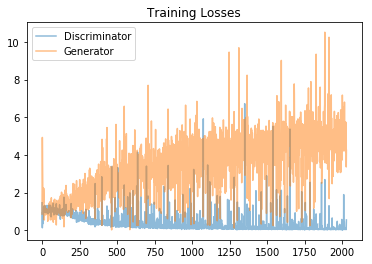

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [23]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [24]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

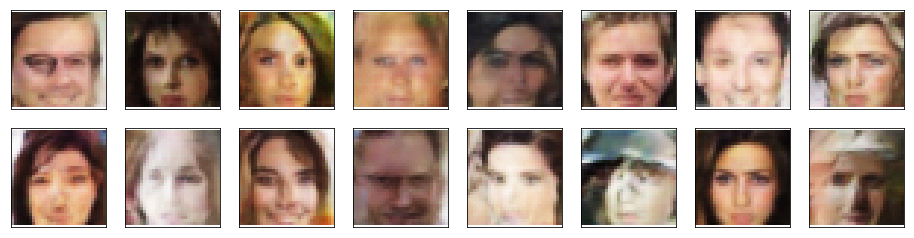

In [25]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
My generated samples look like real people. The resolution of the images need some improvement though. I trained for 50 epochs initially and one of the faces was like an abstract painting. Some of the faces had abstract swatches of colour. With 70 epochs the images are more realistic.

To optimize my model I would:

I would replace my reLu activation function with Leaky ReLu.
I would modify my build a larger model and add some noise in the discriminator.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.